In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from scipy.stats import randint

import os

In [2]:
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")

Numpy version: 2.2.0
Pandas version: 2.2.3
Matplotlib version: 3.10.0


In [3]:
# Default plot styling
plt.rcParams.update({
    'figure.figsize': (12, 8),  # default figure size
    'figure.subplot.hspace': 0.5,
    'figure.subplot.wspace': 0.5,

    'axes.grid': False,
    'axes.grid.axis': 'both',
    'axes.grid.which': 'both',
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.labelpad': 20,
    'axes.labelsize': 12,
    'axes.labelweight': 'bold',
    'axes.titlepad': 20,
    'axes.titlesize': 12,
    'axes.titleweight': 'bold',

    'grid.alpha': 0.4,
    'grid.color': '#eeeeee',
    'grid.linestyle': 'dashed',

    'lines.linestyle': 'dashed',
    'lines.color': '#eeeeee66',

    'xtick.top': False,
    'xtick.bottom': False,
    'xtick.labelbottom': True,
    'ytick.right': False,
    'ytick.left': False,
    'ytick.labelleft': True,
})

In [4]:
# this is purely used for model evaluation. Ignoring until submission
evaluation_df = pd.read_csv("./data/test.csv")

train_df_original = pd.read_csv("./data/train.csv")
train_df, test_df = train_test_split(train_df_original, test_size=0.2, random_state=42)

In [5]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S
361,362,0,2,"del Carlo, Mr. Sebastiano",male,29.0,1,0,SC/PARIS 2167,27.7208,NaN,C
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S


In [6]:
test_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C


# Features

**index**
1. `PassengerId`

**Demographic**
1. `Name` (object - string)
2. `Sex` (categorical - string)
3. `Age` (numeric - float)
4. `SibSp` (numeric - int)
5. `Parch` (numeric - int)

**Fare**
1. `Pclass` (categorical - int)
2. `Cabin` (object - string)
3. `Ticket` (object – string)
4. `Fare` (numeric - float)
5. `Embarked` (categorical)

_likely useful features: person demographics/class, cabin/fare, situational (embarked)_

**Target**
1. `Survived` (bool)

# Problem Definition
_Predict whether a person survived the titanic disaster (boolean classification)._
_We can assume a base model of 50% accuracy with random guessing._
_A slightly more nuanced base model would be to only predict women survive, as that was a general pattern. That assumption would yeild a **base accuracy of 78.8%**._

## Base Heuristic Model

In [7]:
num_male = sum(train_df["Sex"] == "male")
num_female = sum(train_df["Sex"] == "female")
print(f'# males = {num_male}')
print(f'# females = {num_female}')
ratio_female = num_female / (num_female + num_male)

female_survivors = train_df.loc[train_df.Sex == 'female']["Survived"]
rate_female = sum(female_survivors)/len(female_survivors)
print(f"% of women who survived: {rate_female:.2f}")

male_survivors = train_df.loc[train_df.Sex == 'male']["Survived"]
rate_male = sum(male_survivors)/len(male_survivors)
print(f"% of men who survived: {rate_male:.2f}")

# correct when female survivors or male non-survivors
correct_guess = rate_female * ratio_female + (1 - rate_male) * (1 - ratio_female)
print(f"\n'Base Model' Accuracy: {correct_guess: .1%}")

# males = 467
# females = 245
% of women who survived: 0.74
% of men who survived: 0.19

'Base Model' Accuracy:  78.8%


# Data Exploration

## Target variable

In [8]:
survived = train_df.Survived
print(f"% Survivors: {sum(survived) / len(survived):.1%}")

% Survivors: 37.6%


([<matplotlib.axis.XTick at 0x120c89be0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

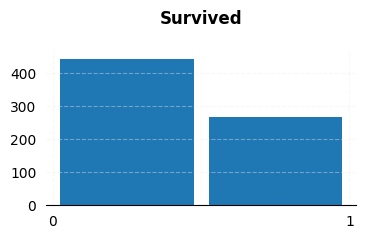

In [9]:
train_df.hist(column='Survived', bins=2, figsize=(4,2), rwidth=0.9)
plt.xticks([0, 1])

## Feature Analysis

### Numerical Features

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [11]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,572.000000,712.000000,712.000000,712.000000
mean,448.234551,0.376404,2.330056,29.498846,0.553371,0.379213,32.586276
std,256.731423,0.484824,0.824584,14.500059,1.176404,0.791669,51.969529
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,453.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,673.500000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Note:
* missing values for Age; will need to impute (strategy: median). Risk: missing values are related to a specific cluster of passengers that is far from median age.
* 2 missing values for embarked; impute with most common value. Low risk given it's only 2 examples.
* Roughly 3/4 have missing cabin values. Leave blank. Too many to impute

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

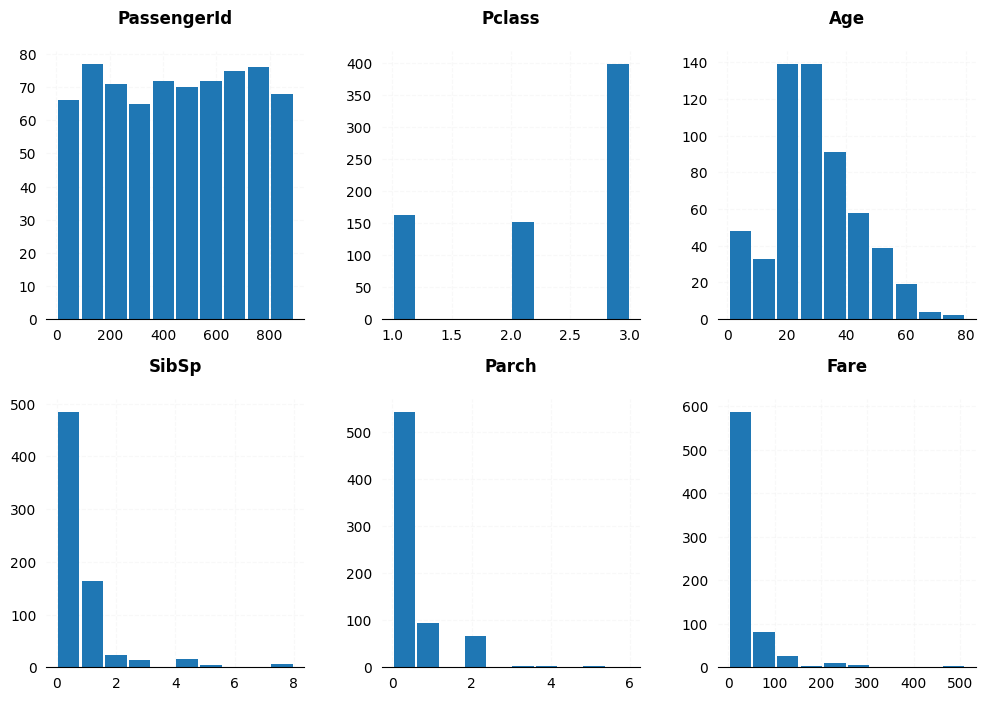

In [12]:
train_df.hist(column=['PassengerId','Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], layout=(2,3), rwidth=0.9, zorder=2)

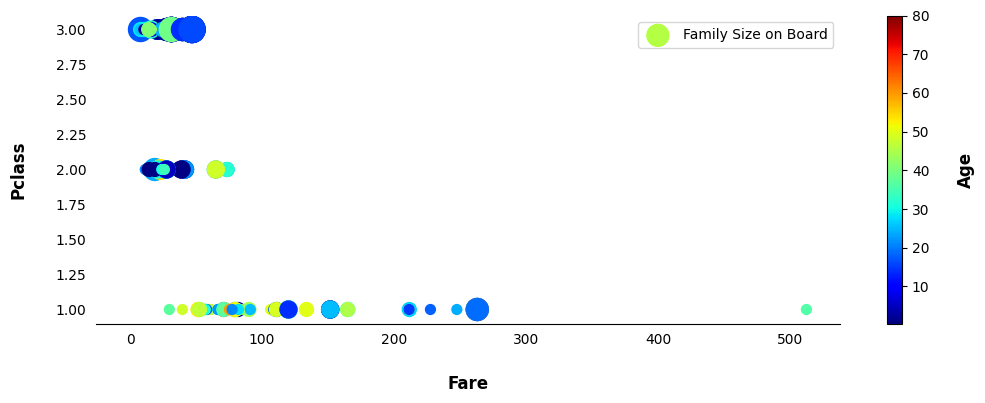

In [13]:
# Analyze if there's a correlation between ticket class and fare
train_df.plot(kind="scatter", y="Pclass", x="Fare",
 s=50*(train_df["Parch"] + train_df["SibSp"]), label="Family Size on Board",
 c="Age", cmap="jet", colorbar=True,
 legend=True, sharex=False, figsize=(12, 4))
plt.show()

#### Thoughts:
* One-hot encode `Pclass`, `Parch`, `Sibsp`
* `Age` looks ok (roughly normal distribution)
* `Fare` can be "power-scaled" (log or sqrt) to transform into normal distribution
* `Pclass` is inverse corrlated with `Fare`

### Object features (strings)

In [14]:
# columns: Sex, Embarked, Cabin, Ticket
print(train_df["Sex"].value_counts())

Sex
male      467
female    245
Name: count, dtype: int64


In [15]:
print(train_df["Embarked"].value_counts())

Embarked
S    525
C    125
Q     60
Name: count, dtype: int64


In [16]:
print(train_df["Ticket"].value_counts())

Ticket
CA. 2343    7
347082      6
1601        6
CA 2144     6
3101295     5
           ..
330923      1
244252      1
349254      1
21440       1
350026      1
Name: count, Length: 558, dtype: int64


In [17]:
print(train_df["Cabin"].value_counts())

Cabin
C23 C25 C27    4
E101           3
B96 B98        3
C22 C26        3
G6             3
              ..
C104           1
D11            1
C86            1
C7             1
C62 C64        1
Name: count, Length: 117, dtype: int64


#### Analysis:
* `Sex` and `Embarked` can be one-hot encoded. Impute Embarked with most common value
* `Ticket`: Split into numerical and categorical component (potentially one-hot encode the latter)
* `Cabin`: Split into numerical and categorical component (potentially one-hot encode the latter)

# Data Preparation

Strategy:
* Impute numericals with median
* Impute strings with most common value
* One-hot encode categorical variables

* `Name`: Tokenize (strip by space and punctuation)
* `Pclass`, `Parch`, `Sibsp`, `Sex`, `Cabin`, `Embarked`: One-hot encode
* `Fare`: leave as is
* `Cabin`: One-hot encode the section, potentially one-hot encode group of rows

Drop rows: Cabin, Ticket, Name

## Data Cleaning

In [18]:
# Drop columns: Cabin, Ticket, Name; Survivor moved to titanic_labels
titanic_data = train_df.drop(["Survived", "Name", "Cabin", "Ticket"], axis=1)
titanic_labels = train_df["Survived"].copy()
print(titanic_data.shape, titanic_labels.shape)

(712, 8) (712,)


In [19]:
# Impute median for all numeric values (needed for Age)
imputer = SimpleImputer(strategy="median")
titanic_num = titanic_data.select_dtypes(include=[np.number])
imputer.fit_transform(titanic_num)

print(imputer.statistics_) # Median age = 28
imputer.feature_names_in_

[453.5      3.      28.       0.       0.      14.4542]


array(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
      dtype=object)

In [20]:
titanic_num.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
331,332,1,45.5,0,0,28.5000
733,734,2,23.0,0,0,13.0000
382,383,3,32.0,0,0,7.9250
704,705,3,26.0,1,0,7.8542
813,814,3,6.0,4,2,31.2750


In [21]:
# Impute most frequent value for Embarked
imputer_cat = SimpleImputer(strategy="most_frequent")
imputer_cat.fit_transform(titanic_data[["Embarked"]])

print(imputer_cat.statistics_) # Most Frequent value = 'S'
imputer_cat.feature_names_in_

['S']


array(['Embarked'], dtype=object)

In [22]:
cat_encoder = OneHotEncoder()
# titanic_cat = titanic_data.select_dtypes(include=[object])
titanic_cat = titanic_data[['Sex', 'Embarked', 'Pclass']]
#titanic_cat.describe()

titanic_cat_1hot = cat_encoder.fit_transform(titanic_cat)
cat_encoder.get_feature_names_out()

array(['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Embarked_nan', 'Pclass_1', 'Pclass_2', 'Pclass_3'], dtype=object)

In [23]:
'''
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
... columns=cat_encoder.get_feature_names_out(),
... index=df_test_unknown.index)
'''

'\ndf_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),\n... columns=cat_encoder.get_feature_names_out(),\n... index=df_test_unknown.index)\n'

## Feature Scaling

<Axes: >

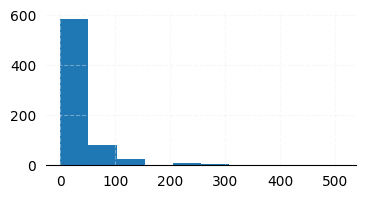

In [24]:
titanic_num["Fare"].hist(figsize=(4,2))

array([[<Axes: title={'center': 'Fare'}>]], dtype=object)

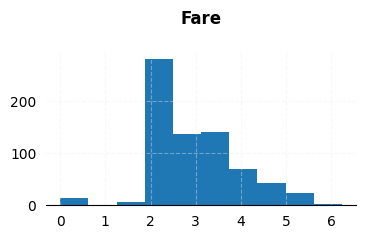

In [25]:
fare_log = titanic_num["Fare"]
fare_log = np.where(fare_log == 0, 1, fare_log) 
fare_log = pd.DataFrame(np.log(fare_log), columns=["Fare"])

fare_log.hist(figsize=(4,2))

In [26]:
titanic_num_adj = titanic_num[["PassengerId", "Age", "SibSp", "Parch", "Fare"]]
titanic_num_adj["Fare"] = fare_log # Update fare with log_adjusted value

std_scaler = StandardScaler()
min_max_scalar = MinMaxScaler()
titanic_num_std_scaled = std_scaler.fit_transform(titanic_num_adj[["Age", "Fare"]])
titanic_num_minmax_scaled = min_max_scalar.fit_transform(titanic_num_adj[["PassengerId", "SibSp", "Parch"]])

/var/folders/db/_76p5qt17bv4c9zl791fx9640000gn/T/ipykernel_84634/492374061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_num_adj["Fare"] = fare_log # Update fare with log_adjusted value


In [27]:
print(titanic_num_std_scaled.shape)
print(titanic_num_minmax_scaled.shape)
print(titanic_cat_1hot.shape)

print(type(titanic_num_std_scaled))
print(type(titanic_num_minmax_scaled))
print(type(titanic_cat_1hot))

(712, 2)
(712, 3)
(712, 9)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse._csr.csr_matrix'>


## Transformation Pipeline

In [28]:
num_std_attribs = ["Age"]
log_attribs = ["Fare"]
num_minmax_attribs = ["PassengerId", "SibSp", "Parch"]
cat_int_attribs = ["Pclass"]
cat_attribs = ["Sex", "Embarked"]

In [29]:
# For Age
num_std_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

# For Fare
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(lambda x: x + 1, feature_names_out="one-to-one"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

# For PassengerId, SibSp, Parch
num_minmax_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler())

# For Pclass
cat_int_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    OneHotEncoder(handle_unknown="ignore"))

# For Sex, Embarked
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num_std", num_std_pipeline, num_std_attribs),
    ("log", log_pipeline, log_attribs),
    ("num_minmax", num_minmax_pipeline, num_minmax_attribs),
    ("cat_int", cat_int_pipeline, cat_int_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [30]:
titanic_prepared = preprocessing.fit_transform(titanic_data)
titanic_prepared_df = pd.DataFrame(
    titanic_prepared, columns=preprocessing.get_feature_names_out(),
    index=titanic_data.index)

In [31]:
titanic_prepared_df

,num_std__Age,log__Fare,num_minmax__PassengerId,num_minmax__SibSp,num_minmax__Parch,cat_int__Pclass_1.0,cat_int__Pclass_2.0,cat_int__Pclass_3.0,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
331,1.253641,0.437404,0.371910,0.000,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
733,-0.477284,-0.322935,0.823596,0.000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
382,0.215086,-0.782201,0.429213,0.000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
704,-0.246494,-0.790325,0.791011,0.125,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
813,-1.785093,0.529116,0.913483,0.500,0.333333,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-0.631144,-0.814128,0.119101,0.000,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
270,-0.092634,0.520387,0.303371,0.000,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
860,0.907456,-0.245215,0.966292,0.250,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
435,-1.169653,1.877220,0.488764,0.125,0.333333,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Correlation Analysis

In [32]:
corr_matrix = train_df[["PassengerId", "Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]].corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.246641
Parch          0.078311
PassengerId    0.019979
SibSp         -0.047602
Age           -0.059695
Pclass        -0.321750
Name: Survived, dtype: float64

In [33]:
# See if total family on board could be useful; looks to be uncorrelated
temp_df = train_df[["PassengerId", "Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]]
temp_df["Family_on_Board"] = temp_df["Parch"] + temp_df["SibSp"]
temp_corr_matrix = temp_df.corr()
temp_corr_matrix["Survived"].sort_values(ascending=False)

/var/folders/db/_76p5qt17bv4c9zl791fx9640000gn/T/ipykernel_84634/1642906041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["Family_on_Board"] = temp_df["Parch"] + temp_df["SibSp"]


Survived           1.000000
Fare               0.246641
Parch              0.078311
PassengerId        0.019979
Family_on_Board    0.003565
SibSp             -0.047602
Age               -0.059695
Pclass            -0.321750
Name: Survived, dtype: float64

In [34]:
test = titanic_prepared_df
test["Survived"] = titanic_labels
corr_matrix = test.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived                   1.000000
cat__Sex_female            0.541750
log__Fare                  0.308958
cat_int__Pclass_1.0        0.259753
cat__Embarked_C            0.159632
cat_int__Pclass_2.0        0.114623
num_minmax__Parch          0.078311
num_minmax__PassengerId    0.019979
cat__Embarked_Q           -0.006097
num_minmax__SibSp         -0.047602
num_std__Age              -0.048588
cat__Embarked_S           -0.134623
cat_int__Pclass_3.0       -0.314174
cat__Sex_male             -0.541750
Name: Survived, dtype: float64

After feature transformations, the most indicative features are:
* Sex
* Fare
* Pclass
* Embarked

# Model Training

## Logistic Regression

In [35]:
log_reg = make_pipeline(preprocessing, LogisticRegression())
log_reg.fit(titanic_data, titanic_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_std',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer-1',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<...
                                                 ('cat_int',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('logisticregression', LogisticRegression())])

In [36]:
titanic_predictions = log_reg.predict(titanic_data)
print(titanic_predictions[:20].round(2))
print(titanic_labels.iloc[:20].values)

[0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1]


In [37]:
log_reg_accuracy = accuracy_score(titanic_predictions, titanic_labels)
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.2%}")

Logistic Regression Accuracy: 80.90%


## Decision Tree

In [38]:
tree_class = make_pipeline(preprocessing, DecisionTreeClassifier(max_depth=5, random_state=42))
tree_class.fit(titanic_data, titanic_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_std',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer-1',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [39]:
tree_class_pred = tree_class.predict(titanic_data)
print(tree_class_pred[:20].round(2))
print(titanic_labels.iloc[:20].values)
tree_class_accuracy = accuracy_score(tree_class_pred, titanic_labels)
print(f"Decision Tree Accuracy: {tree_class_accuracy:.2%}")

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1]
Decision Tree Accuracy: 85.96%


## Random Forest

In [40]:
forest_class = make_pipeline(preprocessing, RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
forest_class.fit(titanic_data, titanic_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_std',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer-1',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, random_state=42))])

In [41]:
forest_class_pred = forest_class.predict(titanic_data)
print(forest_class_pred[:20].round(2))
print(titanic_labels.iloc[:20].values)
forest_class_accuracy = accuracy_score(forest_class_pred, titanic_labels)
print(f"Random Forest Accuracy: {forest_class_accuracy:.2%}")

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1]
Random Forest Accuracy: 86.10%


## Cross-Validation

In [42]:
log_reg_accuracies = cross_val_score(log_reg, titanic_data, titanic_labels, 
                                        scoring="accuracy", cv=10)

In [43]:
pd.Series(log_reg_accuracies).describe()

count    10.000000
mean      0.800548
std       0.086792
min       0.704225
25%       0.735915
50%       0.769073
75%       0.838664
max       0.943662
dtype: float64

In [44]:
tree_class_accuracies = cross_val_score(tree_class, titanic_data, titanic_labels, 
                                        scoring="accuracy", cv=10)

In [45]:
pd.Series(tree_class_accuracies).describe()

count    10.000000
mean      0.799120
std       0.077441
min       0.704225
25%       0.728873
50%       0.790395
75%       0.853580
max       0.915493
dtype: float64

In [46]:
forest_class_accuracies = cross_val_score(forest_class, titanic_data, titanic_labels, 
                                        scoring="accuracy", cv=10)

In [47]:
pd.Series(forest_class_accuracies).describe()

count    10.000000
mean      0.817410
std       0.082602
min       0.732394
25%       0.750000
50%       0.776213
75%       0.891334
max       0.943662
dtype: float64

# Fine Tuning
_**Analysis**: All the models are fairly similar and close to the base heuristic accuracy (79%), but Random Forest is the most promissing to tune_

In [48]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=42)),
])

param_grid = [
 {'random_forest__max_depth': [3, 5, 10, 20],
 'random_forest__max_features': [4, 6, 8],
 'random_forest__n_estimators': [5, 10, 20]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=10,
                           scoring='accuracy')

grid_search.fit(titanic_data, titanic_labels)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_std',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('log',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer-1',
                                                                                          FunctionTransformer(feature_name...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid=[{'random_forest__max_depth': [3, 5, 10, 20],
                          'random_forest__max_features': [4, 6, 8],
                          'random_forest__n_estimators': [5, 10, 20]}],
             scoring='accuracy')

In [49]:
grid_search.best_params_

{'random_forest__max_depth': 5,
 'random_forest__max_features': 6,
 'random_forest__n_estimators': 20}

In [50]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
14,0.022480,0.000063,0.004255,0.000098,5,6,20,"{'random_forest__max_depth': 5, 'random_forest...",0.875000,0.791667,...,0.957746,0.845070,0.774648,0.788732,0.760563,0.774648,0.915493,0.821596,0.069873,1
11,0.021330,0.000071,0.004245,0.000078,5,4,20,"{'random_forest__max_depth': 5, 'random_forest...",0.888889,0.777778,...,0.957746,0.859155,0.802817,0.774648,0.718310,0.746479,0.915493,0.818779,0.077229,2
7,0.015433,0.000197,0.004392,0.000277,3,8,10,"{'random_forest__max_depth': 3, 'random_forest...",0.861111,0.777778,...,0.957746,0.873239,0.732394,0.816901,0.760563,0.760563,0.901408,0.817410,0.073666,3
8,0.021879,0.000308,0.004333,0.000212,3,8,20,"{'random_forest__max_depth': 3, 'random_forest...",0.861111,0.777778,...,0.943662,0.859155,0.760563,0.802817,0.774648,0.760563,0.901408,0.817410,0.066295,3
17,0.023780,0.000160,0.004345,0.000180,5,8,20,"{'random_forest__max_depth': 5, 'random_forest...",0.861111,0.805556,...,0.943662,0.859155,0.774648,0.788732,0.732394,0.746479,0.929577,0.815962,0.075514,5


In [51]:
param_distribs = {'random_forest__max_depth': randint(low=1, high=20),
                  'random_forest__max_features': randint(low=1, high=20),
                  'random_forest__n_estimators': randint(low=1, high=10)}

rnd_search = RandomizedSearchCV(full_pipeline,
                                param_distributions=param_distribs,
                                n_iter=10, cv=10,
                                scoring='accuracy', random_state=42)

rnd_search.fit(titanic_data, titanic_labels)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num_std',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['Age']),
                                                                              ('log',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer-1',
                                                                                                FunctionTransformer(featur...
                   param_distributions={'random_forest__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x120c8b620>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12134cf50>,
                                        'random_forest__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12134f890>},
                   random_state=42, scoring='accuracy')

In [52]:
rnd_search.best_params_

{'random_forest__max_depth': 4,
 'random_forest__max_features': 8,
 'random_forest__n_estimators': 8}

In [53]:
cv_res_rnd = pd.DataFrame(rnd_search.cv_results_)
cv_res_rnd.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res_rnd.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,0.015223,0.000486,0.004693,0.000263,4,8,8,"{'random_forest__max_depth': 4, 'random_forest...",0.833333,0.777778,...,0.929577,0.873239,0.746479,0.802817,0.732394,0.774648,0.901408,0.808998,0.069276,1
1,0.015070,0.000138,0.003917,0.000015,7,19,7,"{'random_forest__max_depth': 7, 'random_forest...",0.861111,0.805556,...,0.845070,0.816901,0.760563,0.830986,0.746479,0.746479,0.901408,0.801878,0.058093,2
0,0.016860,0.001092,0.004297,0.000709,7,15,8,"{'random_forest__max_depth': 7, 'random_forest...",0.861111,0.819444,...,0.830986,0.816901,0.760563,0.830986,0.746479,0.746479,0.901408,0.801858,0.057467,3
2,0.016582,0.000154,0.003961,0.000066,11,11,8,"{'random_forest__max_depth': 11, 'random_fores...",0.847222,0.791667,...,0.830986,0.816901,0.774648,0.788732,0.788732,0.718310,0.859155,0.797692,0.040145,4
4,0.012319,0.000101,0.003930,0.000026,3,2,8,"{'random_forest__max_depth': 3, 'random_forest...",0.847222,0.750000,...,0.915493,0.859155,0.746479,0.732394,0.732394,0.704225,0.873239,0.792117,0.070031,5


## Best Model

In [54]:
final_model = grid_search.best_estimator_ # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.09, 0.13, 0.06, 0.03, 0.02, 0.03, 0.01, 0.11, 0.34, 0.15, 0.02,
       0.01, 0.01])

In [55]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(np.float64(0.3363267634928647), 'cat__Sex_female'),
 (np.float64(0.15465366699768412), 'cat__Sex_male'),
 (np.float64(0.12603896065129763), 'log__Fare'),
 (np.float64(0.10656359917031537), 'cat_int__Pclass_3.0'),
 (np.float64(0.09457345982537292), 'num_std__Age'),
 (np.float64(0.05817448020167613), 'num_minmax__PassengerId'),
 (np.float64(0.03081044222543599), 'cat_int__Pclass_1.0'),
 (np.float64(0.029566113065770318), 'num_minmax__SibSp'),
 (np.float64(0.019188532694584357), 'cat__Embarked_C'),
 (np.float64(0.01512974009967366), 'num_minmax__Parch'),
 (np.float64(0.01146565677263542), 'cat_int__Pclass_2.0'),
 (np.float64(0.011270023537160192), 'cat__Embarked_S'),
 (np.float64(0.006238561265529171), 'cat__Embarked_Q')]

In [56]:
X_test = test_df.drop("Survived", axis=1)
y_test = test_df["Survived"].copy()

final_predictions = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_predictions)
print(f"Final Model Accuracy: {final_accuracy:.2%}")

Final Model Accuracy: 80.45%
